(Rapport pdf du projet en ligne)

# Reconnaissance de chiffres manuscrits (projet 2)

Professeur : Alexis Nasr

Master 1

Aix-Marseille Université

**Introduction**

On s’intéresse à la programmation d’un réseau convolutionnel permettant de reconnaître des chiffres manuscrits.

On entraîne notre modèle avec des données d’apprentissages, et on l’évaluera avec les données test. Les données d’apprentissage sont ici des couples (x i , y i ) où x i est une image de 28 x 28 pixels représentant un chiffre de 0 à 9, et yi est le chiffre correspondant à l’image. Un pixel est représenté par un nombre compris entre 0 et 255 indiquant le niveau de gris du pixel, 0 étant noir et 255, blanc. On a un fichier train_image_file.txt où une ligne correspond à une série de pixels représentant une image d’un chiffre blanc sur un fond noir (x i ). Et dans le fichier train_label_file.txt, à la ligne du même indice, correspond le chiffre représenté par l’image (y i ). La structure est la même pour les fichiers test. On dispose de 60 000 couples (x,y) pour les données train et de 10 000 pour les données test.

Dans nos données d’apprentissage, les chiffres sont centrés sur l’image et on a un certain niveau de gris des pixels, qu’on pourrait qualifier de facilement identifiable. On peut donc chercher à faire des modifications, relatives à ces deux axes, afin de tester le modèle dans d’autres conditions. On va donc s’intéresser en premier lieu à l’augmentation de données par translation d’images, en générant de nouveaux exemples où les images sont décalées vers le haut/bas/droite/gauche. En second lieu, on va se focaliser sur les niveaux de gris, et faire varier la gradation, rendant les chiffres plus ou moins discernables, pour voir l’influence sur les performances du modèle.


On récupère les données de train et de test

In [ ]:
%%bash
wget http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_AA/mnist.tgz
tar xvfz mnist.tgz

On met en forme les données d'apprentissage

In [ ]:
import numpy as np

def lecture_images(nomFichierImages):
    print("lecture des donnees d'entrée depuis le fichier : ", nomFichierImages)
    try:
        fic = open(nomFichierImages, 'r')
    except IOError:
        print("le fichier", nomFichierImages, "n'existe pas")
        return None
    i = 0
    L = []
    for ligne in fic:
      ligne.rstrip()
      ligne = ligne.split()
      i += 1
      for elt in ligne:
        L.append(int(elt))
    L = np.array(L)
    L = L.reshape(i,28,28,1)
    return L


def lecture_labels(nomFichierLabels):
    print("lecture des donnees de sortie depuis le fichier : ", nomFichierLabels)
    try:
        fic = open(nomFichierLabels, 'r')
    except IOError:
        print("le fichier", nomFichierLabels, "n'existe pas")
        return None
    L2 = []
    for ligne in fic:
      one_hot = [0] * 10
      ligne.rstrip()
      classe = int(ligne)
      one_hot[classe] = 1
      L2.append(one_hot)
    L2 = np.array(L2)
    return L2

x_train = lecture_images('data/train_image_file.txt')
y_train = lecture_labels('data/train_label_file.txt')

print('x shape = ', x_train.shape)
print('y shape = ', y_train.shape)

lecture des donnees d'entrée depuis le fichier :  data/train_image_file.txt
lecture des donnees de sortie depuis le fichier :  data/train_label_file.txt
x shape =  (60000, 28, 28, 1)
y shape =  (60000, 10)


Construction et apprentissage du modèle

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



On met en forme les données de test

In [ ]:
x_test = lecture_images('data/test_image_file.txt')
y_test = lecture_labels('data/test_label_file.txt')


lecture des donnees d'entrée depuis le fichier :  data/test_image_file.txt
lecture des donnees de sortie depuis le fichier :  data/test_label_file.txt


On évalue les prédictions sur les données de test

In [ ]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

375/375 [==============================] - 26s 64ms/step - loss: 1.6317 - accuracy: 0.9018 - val_loss: 0.3684 - val_accuracy: 0.9576
Test loss: 0.33898380398750305
Test accuracy: 0.9610000252723694


# I. Augmentation de données
Générons de nouveaux exemples, en réalisant, par exemple, des translations des images, vers le haut, le bas, la gauche ou la
droite.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 0,
    width_shift_range = 0.3,
    height_shift_range = 0.2,
    zoom_range = 0)
datagen.fit(x_train)

translated_images = []
batch_size = 128

for x_batch in datagen.flow(x_train, batch_size=batch_size, shuffle=False):
    translated_images.append(x_batch)
    if len(translated_images) * batch_size >= len(x_train):
        break

# on concatène les images translatées en un seul tableau numpy
translated_images = np.concatenate(translated_images, axis=0)

print('Shape of translated images:', translated_images.shape) # vérification

Shape of translated images: (60000, 28, 28, 1)


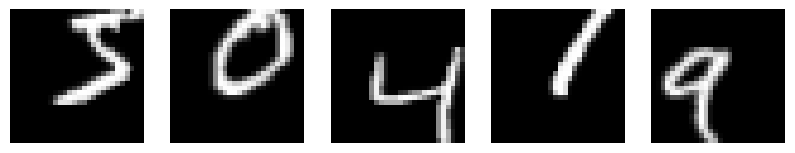

In [ ]:
# génération d'images des 5 premières translatées
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(translated_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# entraînement du modèle des images translatées et évaluation

batch_size = 128
model.fit(translated_images, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


375/375 [==============================] - 21s 55ms/step - loss: 1.8912 - accuracy: 0.5619 - val_loss: 1.0121 - val_accuracy: 0.6794
Test loss: 0.7678507566452026
Test accuracy: 0.7601000070571899


On peut se demander à quel point les translations rendent l’identification difficile, et donc calculer la précision en fonction du niveau de translations des images.

In [ ]:
transformations = {
    "width_shift_range": np.arange(0, 1, 0.3),
    "height_shift_range": np.arange(0, 1, 0.3),
}

loss_augmente, accuracy_augmente = {}, {}
for transformation_name, transformation_values in transformations.items():
    print(f"\nEntraînement du modèle avec {transformation_name}.") # pour suivre l'exécution du code

    loss_values, accuracy_values = [], []
    for transformation_value in transformation_values:
        print(f"Transformation value: {transformation_value}") # pour suivre l'exécution du code
        datagen_train = ImageDataGenerator(**{transformation_name: transformation_value})
        translated_train_data = datagen_train.flow(x_train, y_train, batch_size=batch_size)

        model.fit(translated_train_data, steps_per_epoch=len(x_train) // batch_size, epochs=epochs, verbose=0)

        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        loss_values.append(loss)
        accuracy_values.append(accuracy)

    loss_augmente[transformation_name] = loss_values
    accuracy_augmente[transformation_name] = accuracy_values




Entraînement du modèle avec width_shift_range.
Transformation value: 0.0
Transformation value: 0.3
Transformation value: 0.6
Transformation value: 0.8999999999999999

Entraînement du modèle avec height_shift_range.
Transformation value: 0.0
Transformation value: 0.3
Transformation value: 0.6
Transformation value: 0.8999999999999999


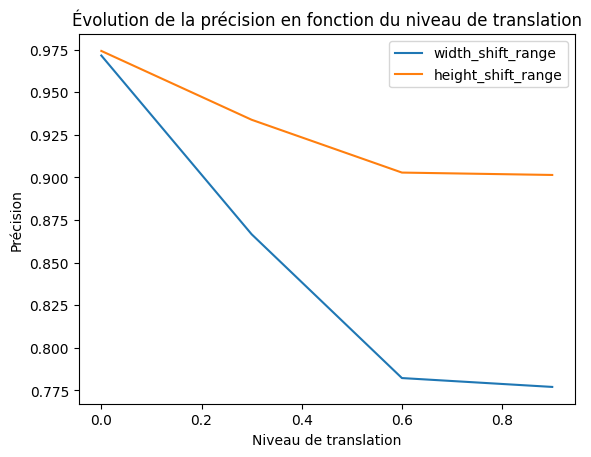

In [ ]:
# Représentation des performances

for transformation_name in transformations.keys():
    plt.plot(transformations[transformation_name], accuracy_augmente[transformation_name], label=transformation_name)

plt.title('Évolution de la précision en fonction du niveau de translation')
plt.xlabel('Niveau de translation')
plt.ylabel('Précision')
plt.legend()
plt.show()

Maintenant on va augmenter la taille des données, et donc concaténer ces données translatées avec celles originales, pour obtenir 120 000 données d'apprentissages.

In [ ]:
augmented_x_train = np.concatenate((x_train,translated_images))
print(len(augmented_x_train)) # vérifier 120 000

y_train = np.concatenate((y_train,y_train)) # on double comme on a doublé avec les translated_images

120000


Entraînement du modèle avec ces 120 000 données d'apprentissage et évaluation

In [ ]:
batch_size = 128
model.fit(augmented_x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


750/750 [==============================] - 36s 47ms/step - loss: 0.5895 - accuracy: 0.8157 - val_loss: 0.9762 - val_accuracy: 0.6905
Test loss: 0.13479796051979065
Test accuracy: 0.9605000019073486


# II. Niveaux de gris

Modifions la gradation du niveau de gris pour voir l'influence sur la reconnaissance du chiffre.

On peut par exemple ajouter à la valeur de chaque pixel un certain nombre (positif ou négatif), ce qui modifie les niveaux de gris.

In [ ]:
import numpy as np

def lecture_images(nomFichierImages):
    print("lecture des donnees d'entrée depuis le fichier : ", nomFichierImages)
    try:
        fic = open(nomFichierImages, 'r')
    except IOError:
        print("le fichier", nomFichierImages, "n'existe pas")
        return None
    i = 0
    L = []
    for ligne in fic:
      ligne.rstrip()
      ligne = ligne.split()
      i += 1
      for elt in ligne:
        L.append(int(elt))
    L = np.array(L)
    L = L.reshape(i,28,28,1)
    return L


def lecture_labels(nomFichierLabels):
    print("lecture des donnees de sortie depuis le fichier : ", nomFichierLabels)
    try:
        fic = open(nomFichierLabels, 'r')
    except IOError:
        print("le fichier", nomFichierLabels, "n'existe pas")
        return None
    L2 = []
    for ligne in fic:
      one_hot = [0] * 10
      ligne.rstrip()
      classe = int(ligne)
      one_hot[classe] = 1
      L2.append(one_hot)
    L2 = np.array(L2)
    return L2

x_train = lecture_images('data/train_image_file.txt')
y_train = lecture_labels('data/train_label_file.txt')


lecture des donnees d'entrée depuis le fichier :  data/train_image_file.txt
lecture des donnees de sortie depuis le fichier :  data/train_label_file.txt


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

x_test = lecture_images('data/test_image_file.txt')
y_test = lecture_labels('data/test_label_file.txt')

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


lecture des donnees d'entrée depuis le fichier :  data/test_image_file.txt
lecture des donnees de sortie depuis le fichier :  data/test_label_file.txt
375/375 [==============================] - 24s 63ms/step - loss: 1.6402 - accuracy: 0.8965 - val_loss: 0.4863 - val_accuracy: 0.9452
Test loss: 0.4464513659477234
Test accuracy: 0.9458000063896179


Modification de la valeur des pixels

In [ ]:
def ajuster_pixels(images, valeur_ajoutee):
    images_ajustees = np.clip(x_train + valeur_ajoutee, 0, 255)
    return images_ajustees

valeur_ajoutee = -230 # par exemple
images_ajustees = ajuster_pixels(x_train, valeur_ajoutee)

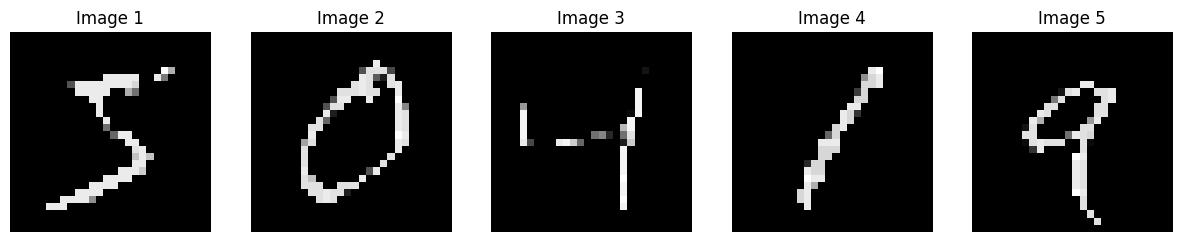

In [ ]:
# Affichage des 5 premiers chiffres après modification des valeurs de pixels

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(images_ajustees[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title('Image {}'.format(i+1))

plt.show()

On veut maintenant évaluer la précision du modèle sur ces images ajustées, en fonction des valeurs suivantes de valeur_ajoutee : -254, -225, -197, -169, -143, -118, -94, -72, -51, -33, 0, 33, 51, 72, 94, 118, 143, 169, 197, 225, 254.

In [ ]:
import matplotlib.pyplot as plt

valeurs_ajoutees = [-254, -225, -197, -169, -143, -118, -94, -72, -51, -33, 0, 33, 51, 72, 94, 118, 143, 169, 197, 225, 254]

precisions = []
loss = []

for valeur_ajoutee in valeurs_ajoutees:
    images_ajustees = ajuster_pixels(x_train, valeur_ajoutee)

    # Entraînement du modèle sur les images ajustées
    model.fit(images_ajustees, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Évaluation du modèle sur les données test
    score = model.evaluate(x_test, y_test, verbose=0)

    precisions.append(score[1])
    loss.append(score[0])

    # Possibilité de printer pendant l'exécution pour voir où on en est
    print('Valeur ajoutée :',valeur_ajoutee)
    print('Précision :', score[1], '(et loss :',score[0],')')

# Représentation graphique de l'accuracy en fonction des valeurs ajoutées
plt.plot(valeurs_ajoutees, precisions, marker='o')
plt.title('Précision du modèle en fonction des valeurs ajoutées')
plt.xlabel('Valeur ajoutée')
plt.ylabel('Précision')
plt.grid(True)
plt.show()